# Analysis framework for rotation period extraction (MSAP4-03)

This notebook provide an example of the analysis performed by the PLATO MSAP4-03 submodules: results from Lomb-Scargle periodogram, autocorrelation functions and composite spectrum are used to produce a set of features exploited by an existing instance of ROOSTER to return the final rotation period of the analysed target. You will find that what is done here is very similar to the ROOSTER tutorial notebook (``rooster_training_framework``, you should run it before doing this tutorial), the only big difference is actually that we will use here a pre-trained ROOSTER instance !

Here, the MSAP4-01A and MSAP4-02 steps required to feed MSAP4-03 are included in order to be able to run this notebook independently from the MSAP4-01A and MSAP4-02 notebooks.

Note that, due its significant computing time, the MSAP4-01B component dedicated to background analysis is executed independently in another notebook.

**Note:** This notebook has been designed for the purpose of scientific justification of MSAP4-03. The notebook illustrated the precise flowchart envisaged for MSAP4-03 is cs_rooster_sph_analysis.ipynb

In [1]:
import star_privateer as sp

In [2]:
sp.__version__

'1.1.1'

## A simple example

In [3]:
import os, pathos
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists ('stellar_analysis_features') :
    os.mkdir ('stellar_analysis_features')  

Our working case is KIC 3733735, a well-known *Kepler* fast rotating star.

In [4]:
filename = sp.get_target_filename (sp.timeseries, '003733735')
t, s, dt = sp.load_resource (filename)

The first thing we have to do is run the analysis pipeline. In particular, we can take a look at the plots made from the different analysis methods. 

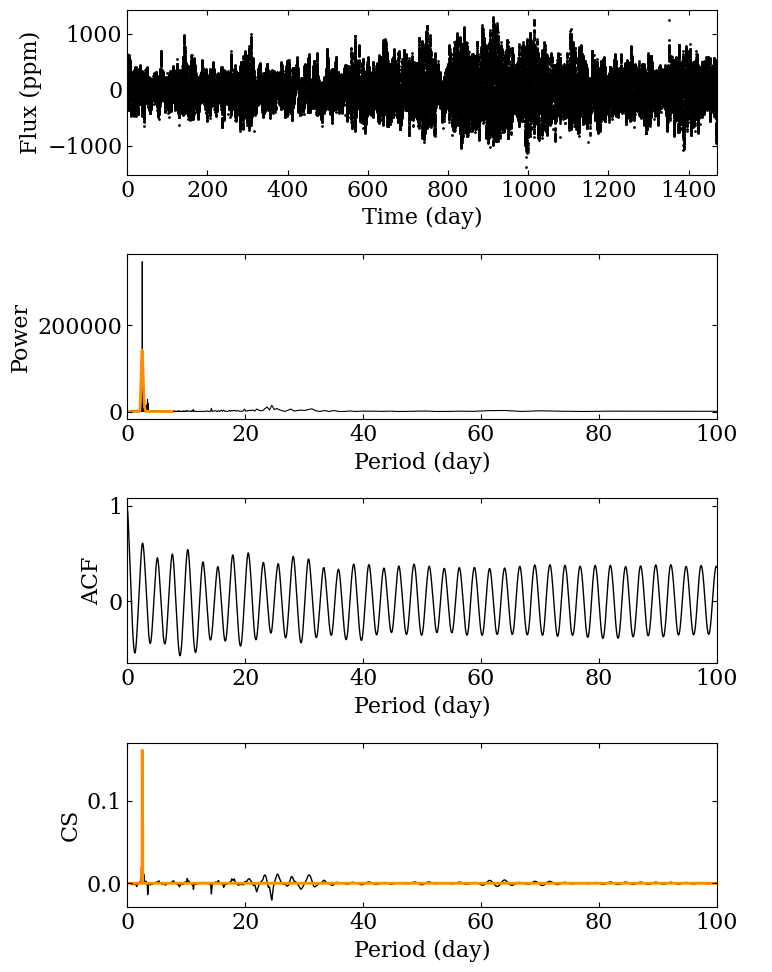

In [5]:
(p_ps, p_acf, ps, acf, 
 cs, features, feature_names, _) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60, figsize=(8,10),
                                                            wavelet_analysis=False, plot=True,
                                                            filename='stellar_analysis_features/003733735.png',
                                                        )

We then save the results to a csv file:

In [6]:
fileout = 'stellar_analysis_features/003733735.csv'
df = sp.save_features (fileout, 3733735, features, feature_names)

As in the previous tutorial, let's build a feature catalog. This is actually not required here because we are analysing only one star, but this step allows to ROOSTER-analyse several stars together with a simple framework.

In [7]:
df = sp.build_catalog_features ('stellar_analysis_features')

Then, let's load the ROOSTER instance that we have trained in the previous tutorial:

In [8]:
chicken = sp.load_rooster_instance (filename='rooster_instances/rooster_tutorial')

As previously, let's split the DataFrame into ROOSTER required inputs:

In [9]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)

Here, we can see that there is actually (almost) nothing to do, as the three methods have yielded the same $P_\mathrm{rot}$ estimate. However, we need ROOSTER to provide us with the rotation score of the target. ROOSTER will also select one of the three ``p_candidates`` as the final estimate for our target.

In [10]:
p_candidates

array([[2.53459872, 2.63594132, 2.56168138]])

The ``analyseSet`` function implemented in ROOSTER allows to analyse the features we extracted with the analysis pipeline. By providing ``feature_names``, we ensure that ROOSTER was trained with the same features that those we extracted.

In [11]:
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

We finally get the rotation score and the final $P_\mathrm{rot}$. A rotation score above 0.5 means that the ROOSTER analysis favours a detection of stellar surface rotation signal.

In [12]:
rotation_score, prot, e_p, E_p

(array([0.78]), array([2.53459872]), array([0.21810524]), array([0.2634447]))

## Analysing a PLATO simulated light curves dataset

In order to illustrate the pipeline features described above, we can apply the pipeline to a larger dataset of 255 PLATO simulated light curves in order to check what we recover.

In [13]:
import plato_msap4_demonstrator_datasets.plato_sim_dataset as plato_sim_dataset

if not os.path.exists ('plato_sim_features') :
    os.mkdir ('plato_sim_features')

In [14]:
list_id = sp.get_list_targets (plato_sim_dataset)

Just as in the ROOSTER tutorial, we define a dedicated wrapper to analyse several light curves in parallel and avoid any memory leakage. Note than, we apply a 60-day high-pass finite impulse response filter to the simulated light curves (`preprocess`) function in order to remove low-frequency systematics while preserving at most the signature of stellar surface rotation in the data. 

In [15]:
def analysis_wrapper (star_id) :
    """
    Analysis wrapper to speed computation
    by parallelising process and control
    memory usage.
    """
    star_id = str (star_id).zfill (3)
    fileout = 'plato_sim_features/{}.csv'.format(star_id)
    fileplot = 'plato_sim_features/{}.png'.format(star_id)
    filename = sp.get_target_filename (plato_sim_dataset, star_id, filetype='csv')
    if not os.path.exists (fileout) :
        t, s, dt = sp.load_resource (filename)
        s = sp.preprocess (t, s, cut=60)
        (p_ps, p_acf, 
         ps, acf, 
         cs, features, 
         feature_names, fig) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60, plot=True,
                                                     wavelet_analysis=False, filename=fileplot,
                                                     figsize=(10,16), lw=1, dpi=300)
        df = sp.save_features (fileout, star_id, features, feature_names)
        plt.close ("all")

Let's run the process pool:

In [16]:
process_pool = pathos.pools._ProcessPool (processes=4, 
                                          maxtasksperchild=10)
with process_pool as p :
    list (tqdm (p.imap (analysis_wrapper,
                        list_id,
                        ),
                total=len (list_id))
          )
    p.close ()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 843.21it/s]


We can now analyse the obtained features with ROOSTER to provide our final results.

In [17]:
df = sp.build_catalog_features ('plato_sim_features')
df

,prot_ps,prot_acf,prot_cs,e_prot_ps,E_prot_ps,e_prot_acf,E_prot_acf,e_prot_cs,E_prot_cs,sph_ps,sph_acf,sph_cs,h_ps,fa_prob_ps,hacf,gacf,hcs
target_id,,,,,,,,,,,,,,,,,
0,42.955113,36.201157,43.493698,5.139282,6.755867,-1.0,-1.0,1.911796,1.911796,809.302045,770.019836,804.306555,4.573669e+06,0.0,0.522076,0.174793,0.804396
1,33.388871,32.603958,33.124768,7.850812,14.820267,-1.0,-1.0,5.027412,5.027412,197.317073,196.573468,196.860684,5.452245e+03,0.0,0.095639,0.045796,0.527596
2,17.529157,18.062384,17.308610,1.997207,2.586628,-1.0,-1.0,0.424356,0.424356,131.463440,132.741191,131.613358,9.626133e+03,0.0,0.226074,0.162293,0.137714
3,21.247463,20.791534,20.918945,2.308992,2.950196,-1.0,-1.0,0.729080,0.729080,108.132491,108.613715,108.524835,1.468874e+04,0.0,0.316458,0.308489,0.075097
4,28.636742,28.770649,29.353447,3.606657,4.821026,-1.0,-1.0,1.331297,1.331297,156.739595,156.556259,156.091130,8.556843e+02,0.0,0.021029,0.021854,0.433539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,31.871195,29.319257,31.239800,9.996470,26.822076,-1.0,-1.0,4.055894,4.055894,213.718124,204.408037,215.372660,4.368693e+04,0.0,0.832173,0.428776,0.880686
251,20.214171,19.027656,20.212371,1.917448,2.366382,-1.0,-1.0,1.729649,1.729649,187.913408,178.586179,187.910206,8.072857e+04,0.0,0.688937,0.313818,0.835033
252,36.903489,37.805314,36.899833,5.608447,8.057559,-1.0,-1.0,5.558169,5.558169,1488.425513,1505.598715,1488.392507,8.011975e+06,0.0,1.508467,0.751838,0.976312


In [18]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

Next, let's load the reference catalog for these simulated light curves in order to compare the results from our pipeline with what was injected in the data.

In [19]:
prot_ref = sp.get_prot_ref (target_id, catalog='plato-sim')
cond_0 = (rotation_score>0.5)
cond_1 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) 
cond_2 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) & (rotation_score>0.5)
score_0 = target_id[cond_0].size / target_id.size
score_1 = target_id[cond_1].size / target_id.size
score_2 = target_id[cond_2].size / target_id.size
score_0, score_1, score_2

(0.9450980392156862, 0.615686274509804, 0.596078431372549)

The score computed here means that we were able to successfully detect a rotation signal and recover the correct rotation period for about **61% of the stars** in the sample. We can take a look at histograms to check the rotation score of our population and to compare the input rotation periods distribution to the one we recover.

(0.0, 80.0)

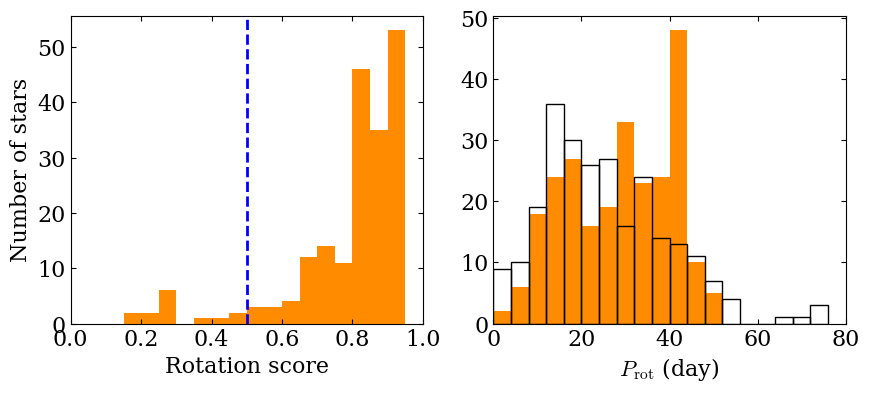

In [20]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

bins = np.linspace (0, 1, 20, endpoint=False)
ax1.hist (rotation_score, bins=bins, color='darkorange')
ax1.axvline (0.5, ls='--', color='blue', lw=2)
bins = np.linspace (0, 80, 20, endpoint=False)
ax2.hist (prot, bins=bins, color='darkorange')
ax2.hist (prot_ref, bins=bins, facecolor='none',
         edgecolor='black', label='Ref')

ax1.set_ylabel (r'Number of stars')
ax1.set_xlabel (r'Rotation score')
ax2.set_xlabel (r'$P_\mathrm{rot}$ (day)')

ax1.set_xlim (0, 1)
ax2.set_xlim (0, 80)